# **This file is to run code to produce standardized dataframe for the Summer 2025 SULI appointment**
#### *Coded by Brandon Swanson<br>Mentored by Bhupendra Raut*

In [4]:
import numpy as np
import xarray as xr
from itertools import combinations
from sklearn.preprocessing import StandardScaler, MinMaxScaler

def normalize(data, method='minmax'):
    if method == 'standard':
        scaler = StandardScaler()
    elif method == 'minmax':
        scaler = MinMaxScaler()
    else:
        raise ValueError
    return scaler.fit_transform(data)

def main():
    # Load dataset
    file = xr.open_dataset('D://Data//crocus_neiu_a1_and_filtered_30min.nc', engine='netcdf4')
    
    # Extract variables and convert to numpy arrays
    variables = ['pm2.5', 'pm1.0','pm10.0', 'co', 'no', 'o3', 'no2', 'temperature', 'dewpoint', 'u_wind', 'v_wind']
    data_arrays = [file[var].to_numpy().ravel() for var in variables]
    
    # Mask NaN values
    mask = np.all([~np.isnan(arr) for arr in data_arrays], axis=0)
    cleaned_data = np.column_stack([arr[mask] for arr in data_arrays])

    X = normalize(cleaned_data, method='minmax')

    print(X)
    # normalize(variables, cleaned_data)

if __name__ == '__main__':
    main()

[[0.10351291 0.10423372 0.08973381 ... 0.42588297 0.42252071 0.28984338]
 [0.08259682 0.08346012 0.07085881 ... 0.37549676 0.40281174 0.25880392]
 [0.08458292 0.08631283 0.07154831 ... 0.37740397 0.36866807 0.3520308 ]
 ...
 [0.00352532 0.00131664 0.00552029 ... 0.51326568 0.18432755 0.46284348]
 [0.00374876 0.00117034 0.00538239 ... 0.52167557 0.2332618  0.34339178]
 [0.00409633 0.00137515 0.00645111 ... 0.52961455 0.26138646 0.440772  ]]


       pm2.5      pm1.0     pm10.0        co        no        o3       no2  \
0  28.350000  24.050000  35.450000  0.218233  0.012033  0.027467  0.013567   
1  22.733333  19.316667  28.150000  0.179633  0.012567  0.022667  0.009133   
2  23.266667  19.966667  28.416667  0.173333  0.013800  0.020900  0.010767   
3  20.916667  17.783333  25.566667  0.179433  0.016300  0.022067  0.010200   
4  19.633333  16.633333  23.583333  0.185333  0.017000  0.022133  0.008800   
5  19.766667  17.050000  24.183333  0.183633  0.017033  0.014800  0.010433   
6  12.483333  10.800000  15.716667  0.151800  0.016567  0.010233  0.008633   
7   6.500000   5.566667  10.016667  0.114400  0.016900  0.008167  0.006300   
8   5.966667   5.150000   9.050000  0.095667  0.017167  0.006633  0.005833   
9   5.800000   5.033333   8.483333  0.083400  0.017167  0.006633  0.006000   

   temperature  dewpoint    u_wind    v_wind  cluster  
0    15.220000  7.995897 -1.607238 -1.670666        0  
1    14.220000  6.396147 -1.8

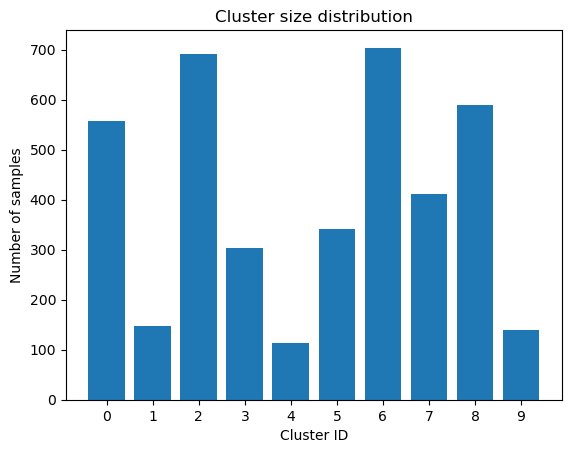

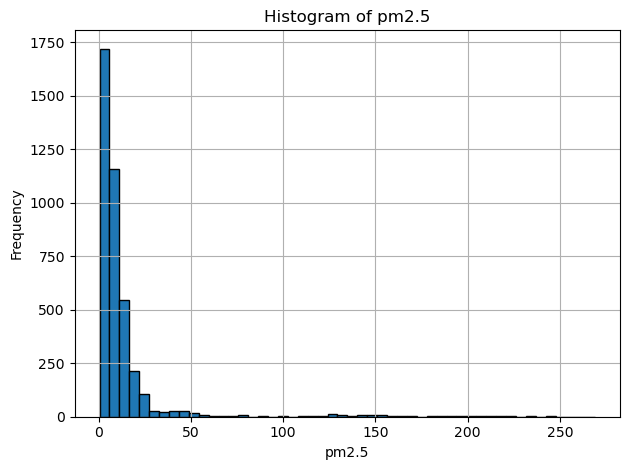

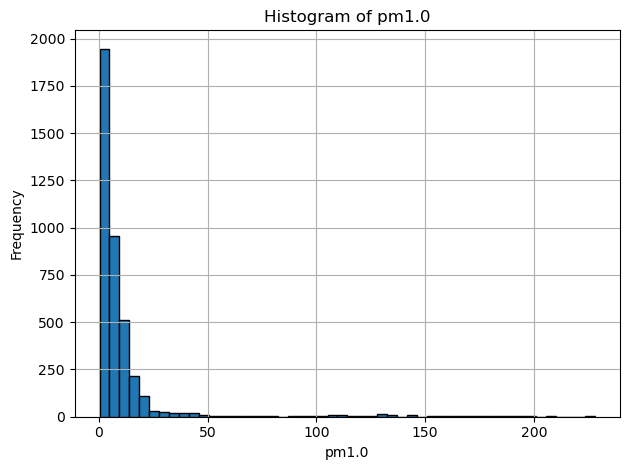

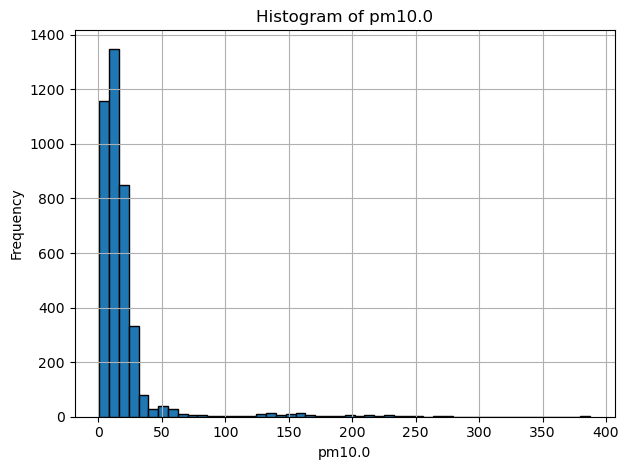

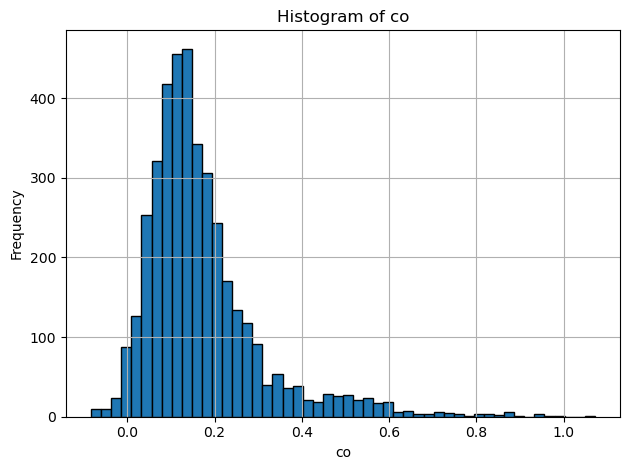

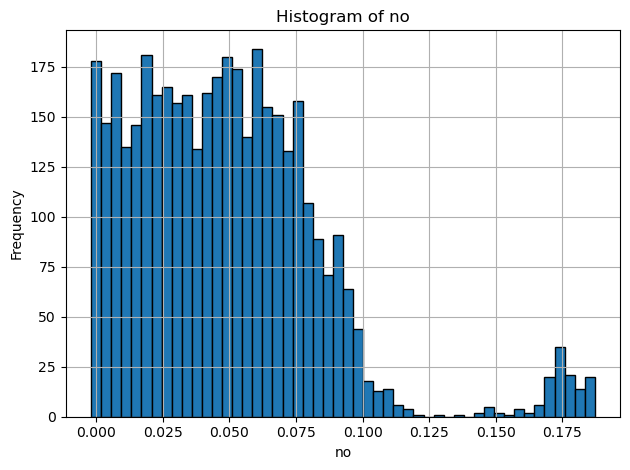

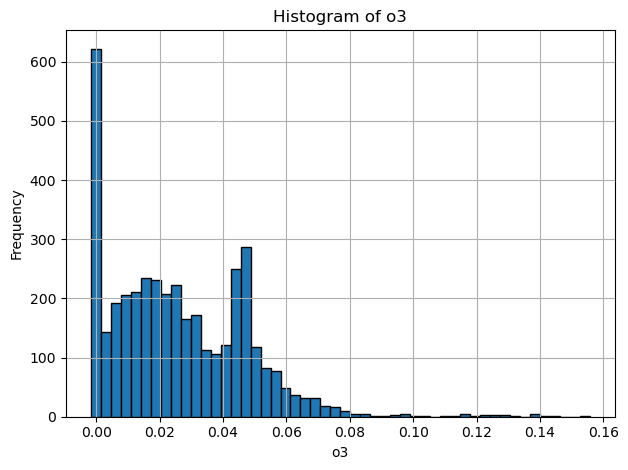

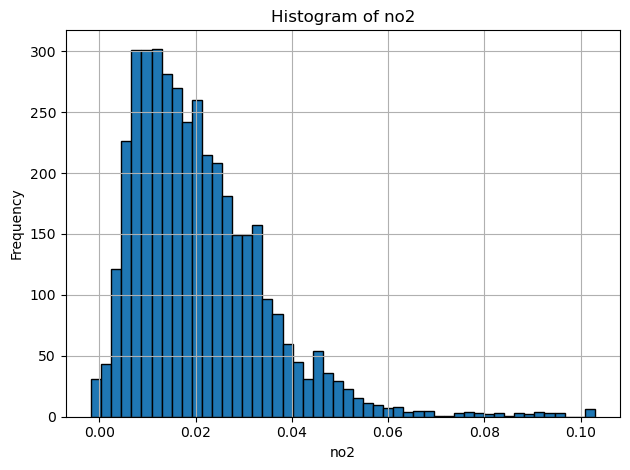

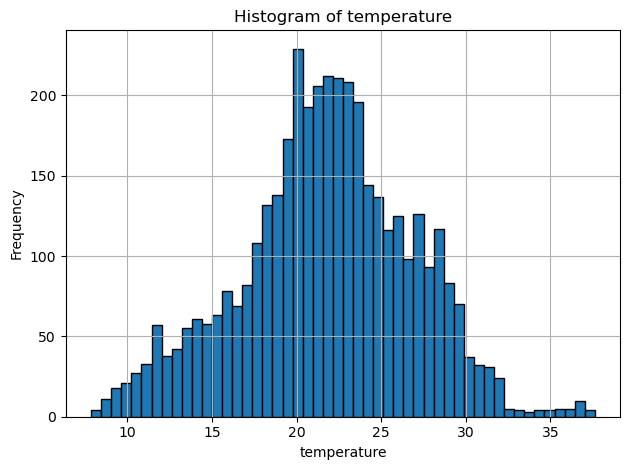

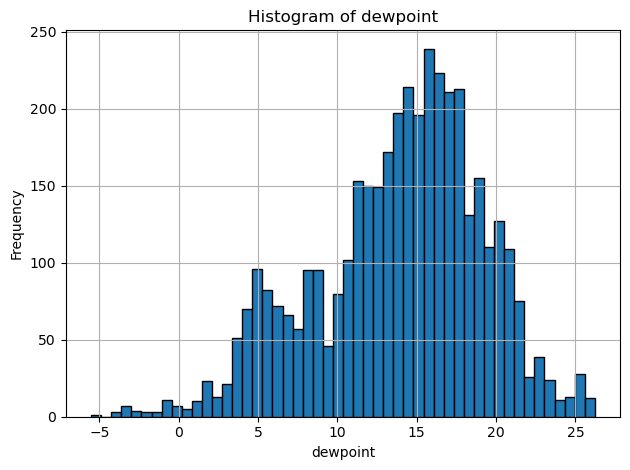

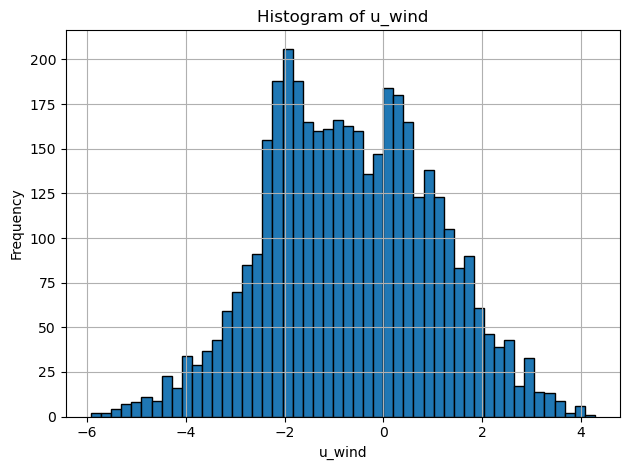

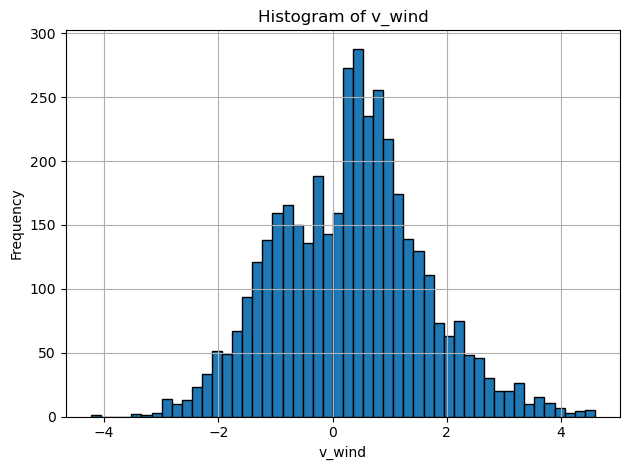

In [20]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler  # or MinMaxScaler
from sklearn.cluster import KMeans

def load_and_clean(ds_path, variables):
    ds = xr.open_dataset(ds_path, engine='netcdf4')
    # pull each var into a 1-D array
    arrays = [ds[v].to_numpy().ravel() for v in variables]
    # mask out any row with at least one NaN
    mask   = np.all([~np.isnan(a) for a in arrays], axis=0)
    data   = np.column_stack([a[mask] for a in arrays])
    # build DataFrame
    df     = pd.DataFrame(data, columns=variables)
    return df

def normalize_df(df, method='standard'):
    if method == 'standard':
        scaler = StandardScaler()
    else:  # method == 'minmax'
        from sklearn.preprocessing import MinMaxScaler
        scaler = MinMaxScaler()
    norm_vals = scaler.fit_transform(df.values)
    # return a new DataFrame of normalized values (same columns)
    return pd.DataFrame(norm_vals, columns=df.columns, index=df.index)

def cluster_and_attach(df, n_clusters=10):
    # run k-means on the normalized version of df
    df_norm = normalize_df(df, method='standard')
    
    km = KMeans(n_clusters=n_clusters, random_state=42)
    labels = km.fit_predict(df_norm)
    
    # add the labels back into the original df
    df['cluster'] = labels
    return df

def main():
    vars_list = ['pm2.5','pm1.0','pm10.0','co','no','o3','no2', 'temperature','dewpoint','u_wind','v_wind']
    df = load_and_clean('D://Data//crocus_neiu_a1_and_filtered_30min.nc', vars_list)
    df_with_clusters = cluster_and_attach(df, n_clusters=10)
    
    print(df_with_clusters.head(10))
    
    counts = df_with_clusters['cluster'].value_counts().sort_index()

    plt.figure()  # each chart should be its own figure
    plt.bar(counts.index, counts.values)
    plt.xlabel('Cluster ID')
    plt.ylabel('Number of samples')
    plt.title('Cluster size distribution')
    plt.xticks(range(10))  # show ticks 0 through 9
    plt.show()

    vars_to_plot = [col for col in df_with_clusters.columns if col != 'cluster']

    for var in vars_to_plot:
        plt.figure()                  # start a new figure
        df_with_clusters[var].hist(   # pandas’ built-in hist
            bins=50,                  # you can tweak the number of bins
            edgecolor='black'         # optional: draw bin edges in black
        )
        plt.title(f'Histogram of {var}')
        plt.xlabel(var)
        plt.ylabel('Frequency')
        plt.tight_layout()            # nice padding
        plt.show()

if __name__ == '__main__':
    main()
